TRAINING AND TESTING MODEL WITH SINGLE SNR VALUE:
SNR (dB)    ACCURACY  

0           0.53250   
1           0.50500   
2           0.62000   
3           0.59250   
4           0.64750   
5           0.62000   
6           0.65250   
7           0.66000   
8           0.70250   
9           0.71750   
10          0.69500   
11          0.72500   
12          0.75500   
13          0.79250   
14          0.79000   
15          0.81750   
16          0.81750   
17          0.76000   
18          0.84500   
19          0.86000   
20          0.85500   

MODEL- TRAINED WITH ALL SNR VALUES; TESTING WITH EACH SNR VALUE SIGNAL
SNR (dB)    ACCURACY  

0           0.54000   
1           0.61250   
2           0.57000   
3           0.59250   
4           0.57500   
5           0.67250   
6           0.60750   
7           0.63000   
8           0.68250   
9           0.71750   
10          0.69250   
11          0.72250   
12          0.73500   
13          0.69000   
14          0.67250   
15

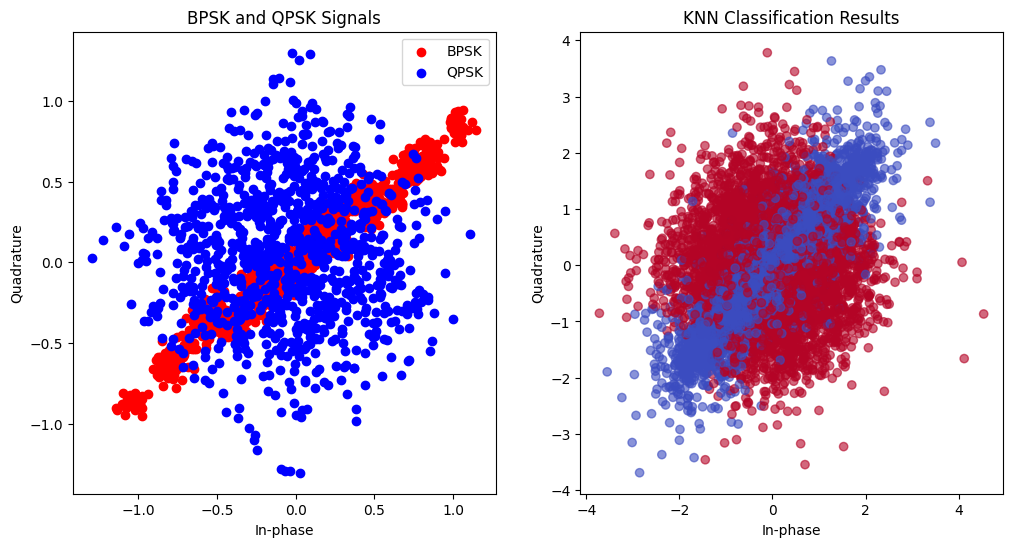

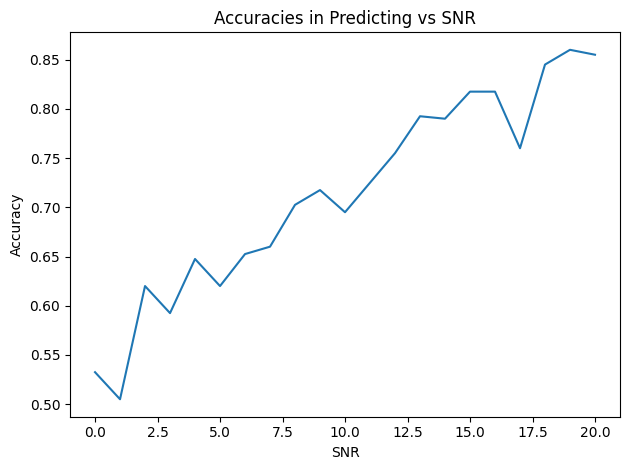

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import numpy as np

def generate_bpsk_signal(num_samples, SNR_dB):
    Kr = 10
    power = 1
    s = np.sqrt((Kr / 2) * (Kr + 1) * power)
    sigma = power / np.sqrt(2 * (Kr + 1))
    path_delays = np.array([0, 200, 800, 1200, 2300, 3700]) * 1e-9
    avg_path_gains = np.array([0, -0.9, -4.9, -8, -7.8, -23.9])

    n_tap = len(avg_path_gains)

    tap_var = 10 ** (avg_path_gains / 10)
    tap_var = tap_var / np.sum(tap_var)

    hn1 = (1 / np.sqrt(2)) * (1 / np.sqrt(n_tap)) * sigma * np.sqrt(tap_var) * \
          ((np.random.randn(1, len(tap_var)) + s) + 1j * (np.random.randn(1, len(tap_var)) + s))

    bits = np.random.randint(0, 2, num_samples)
    symbols = 2 * bits - 1

    faded_signal = np.zeros(num_samples, dtype=complex)
    for i in range(n_tap):
        faded_signal += hn1[0, i] * np.roll(symbols, i)

    noise = (1 / np.sqrt(2)) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))
    SNR_linear = 10**(SNR_dB / 10.0)
    noise_power = np.var(faded_signal) / SNR_linear
    noisy_symbols = faded_signal + np.sqrt(noise_power) * noise

    return noisy_symbols

def generate_qpsk_signal(num_samples, SNR_dB):
    Kr = 10
    power = 1
    s = np.sqrt((Kr / 2) * (Kr + 1) * power)
    sigma = power / np.sqrt(2 * (Kr + 1))
    path_delays = np.array([0, 200, 800, 1200, 2300, 3700]) * 1e-9
    avg_path_gains = np.array([0, -0.9, -4.9, -8, -7.8, -23.9])

    n_tap = len(avg_path_gains)

    tap_var = 10 ** (avg_path_gains / 10)
    tap_var = tap_var / np.sum(tap_var)

    hn1 = (1 / np.sqrt(2)) * (1 / np.sqrt(n_tap)) * sigma * np.sqrt(tap_var) * \
          ((np.random.randn(1, len(tap_var)) + s) + 1j * (np.random.randn(1, len(tap_var)) + s))

    bits = np.random.randint(0, 4, num_samples)
    symbols = np.exp(1j * (np.pi / 4 + np.pi / 2 * bits))

    faded_signal = np.zeros(num_samples, dtype=complex)
    for i in range(n_tap):
        faded_signal += hn1[0, i] * np.roll(symbols, i)

    noise = (1 / np.sqrt(2)) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))
    SNR_linear = 10**(SNR_dB / 10.0)
    noise_power = np.var(faded_signal) / SNR_linear
    noisy_symbols = faded_signal + np.sqrt(noise_power) * noise

    return noisy_symbols


def extract_features(signal):
    features = np.vstack((np.real(signal), np.imag(signal))).T
    return features

X_train = []
Y_train = []

accuracies = []
SNRs = []

print(f"TRAINING AND TESTING MODEL WITH SINGLE SNR VALUE:\n{'SNR (dB)':<12}{'ACCURACY':<10}\n")

num_samples = 1000

for i in range(0, 21):
    SNR_dB = i
    SNRs.append(i)

    bpsk_signal = generate_bpsk_signal(num_samples, SNR_dB)
    qpsk_signal = generate_qpsk_signal(num_samples, SNR_dB)

    bpsk_features = extract_features(bpsk_signal)
    qpsk_features = extract_features(qpsk_signal)

    bpsk_labels = np.zeros(num_samples)
    qpsk_labels = np.ones(num_samples)

    X_train.append(bpsk_features[:800])                                         #Training dataset loaded with first 800 out of 1000 signals of BPSK and QPSK for each SNR value 800+800 = 1600 signals
    X_train.append(qpsk_features[:800])                                         #SNRs 0 to 20 - total 21 SNR values ------ 1600*21 = 33,600 signals in training dataset
    Y_train.append(bpsk_labels[:800])
    Y_train.append(qpsk_labels[:800])

    X_temp = np.vstack((bpsk_features, qpsk_features))
    Y_temp = np.hstack((bpsk_labels, qpsk_labels))

    X_tr, X_te, y_tr, y_te = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    k = 3
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr, y_tr)

    y_pr = knn.predict(X_te)
    acc = accuracy_score(y_te, y_pr)
    print(f"{SNR_dB:<12}{acc:<10.5f}")
    accuracies.append(acc)

X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)

shuffle_index_train = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index_train]
Y_train = Y_train[shuffle_index_train]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)

print(f"\nMODEL- TRAINED WITH ALL SNR VALUES; TESTING WITH EACH SNR VALUE SIGNAL\n{'SNR (dB)':<12}{'ACCURACY':<10}\n")

X_test_all = []
Y_test_all = []
y_preds_all = []

for SNR_dB in SNRs:
    bpsk_signal = generate_bpsk_signal(num_samples, SNR_dB)
    qpsk_signal = generate_qpsk_signal(num_samples, SNR_dB)

    bpsk_features = extract_features(bpsk_signal)
    qpsk_features = extract_features(qpsk_signal)

    bpsk_labels = np.zeros(num_samples)
    qpsk_labels = np.ones(num_samples)

    X_test = np.vstack((bpsk_features[800:], qpsk_features[800:]))              #Test dataset loaded with last 200 signals from BPSK and QPSK - 400 signals from each SNR value .
    Y_test = np.hstack((bpsk_labels[800:], qpsk_labels[800:]))

    shuffle_index_test = np.random.permutation(len(X_test))
    X_test = X_test[shuffle_index_test]
    Y_test = Y_test[shuffle_index_test]

    X_test = scaler.transform(X_test)

    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)

    print(f"{SNR_dB:<12}{accuracy:<10.5f}")

    X_test_all.append(X_test)                                                   #tracked for plotting scatter-plot
    Y_test_all.append(Y_test)
    y_preds_all.append(y_pred)

X_test_all = np.vstack(X_test_all)
Y_test_all = np.hstack(Y_test_all)
y_preds_all = np.hstack(y_preds_all)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(bpsk_features[:, 0], bpsk_features[:, 1], color='r', label='BPSK')
plt.scatter(qpsk_features[:, 0], qpsk_features[:, 1], color='b', label='QPSK')
plt.title("BPSK and QPSK Signals")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_test_all[:, 0], X_test_all[:, 1], c=y_preds_all, cmap='coolwarm', alpha=0.6)
plt.title("KNN Classification Results")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")

plt.figure()
plt.plot(SNRs, accuracies)
plt.title("Accuracies in Predicting vs SNR")
plt.xlabel("SNR")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()